## Machine Learnt Patterns in Rhodium-Catalysed Asymmteric Michael Addition Using Chiral Diene Ligands

# Welcome to the Jupyter Notebook 
This notebook has been designed as a walk-through guide for each section of our Machine Learning workflow. Here we will train Linear Regression and Random Forests models to find relationships between diene ligands
and the asymmetric Michael Addition they perform

## Importing Libraries
The first part of any python code is installing and calling the appropriate "libraries".
Libraries are prewritten code that perform lots of work for us behind the scenes.
This means less writing code from scratch.
Libraries are maintained by different groups and can be downloaded as and when needed for your project.


Here we are using Pandas, numpy, math, sys and sklearn (aka sci-kit learn).



In [1]:
import pandas as pd
import numpy as np
import math

from sys import exit

from IPython.display import clear_output

from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt


With the libraries loaded - or just parts of them - we now move into the main code.

## Opening the dataset

Here we choose the name of the file we want to use. In our example, the data has been split into 4 subsets: 'Acyclic', 'Cyclic', 'Cyclohexenone' and 'Combined'. The name of the file can be changed here for use on other datasets.

In [2]:
filename = 'acyclic.csv'

Next we define our 'list' of feature names (basically the headings from our CSV file). We can choose as many (or as few) features as we like. 
We must also define which variable in the csv file is our target variable.
The CSV file is read in using the pandas read_csv function, creating something called a dataframe. We then filter the dataframe to only contain the features that we want to use (remove any extra columms).
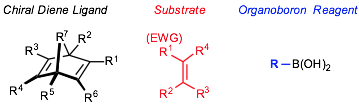


In [3]:
features = ['LVR1', 'LVR2', 'LVR3', 'LVR4', 'LVR5', 'LVR6', 'LVR7' 
            'ER1', 'ER2', 'ER3', 'ER4', 'ER5', 'ER6', 'ER7', 
            'SStoutR1', 'SStoutR2', 'SStoutR3', 'SStoutR4', 'VB']
target_variable = '%top'
features.append(str(target_variable))

data = pd.read_csv(filename)
data = data.filter(features)

With the data read in we also remove any rows containing erroneous or missing values

In [4]:
data = data.dropna(axis=0)
print(data)

           LVR1  LVR2  LVR3       LVR4       LVR5  LVR6   ER2  ER3   ER4  ER5  \
0     94.184290   0.0   0.0  94.184290   0.000000   0.0  0.00  0.0 -0.09  0.0   
1     94.184290   0.0   0.0  94.184290   0.000000   0.0  0.00  0.0 -0.09  0.0   
2     94.184290   0.0   0.0  94.184290   0.000000   0.0  0.00  0.0 -0.09  0.0   
3     94.184290   0.0   0.0  94.184290   0.000000   0.0  0.00  0.0 -0.09  0.0   
4     76.888305   0.0   0.0  76.888305  21.574215   0.0 -0.17  0.0 -0.01  0.0   
..          ...   ...   ...        ...        ...   ...   ...  ...   ...  ...   
174  216.387491   0.0   0.0  21.574215   0.000000   0.0  0.00  0.0 -0.17  0.0   
175  216.387491   0.0   0.0  21.574215   0.000000   0.0  0.00  0.0 -0.17  0.0   
176  216.387491   0.0   0.0  21.574215   0.000000   0.0  0.00  0.0 -0.17  0.0   
177  216.387491   0.0   0.0  21.574215   0.000000   0.0  0.00  0.0 -0.17  0.0   
178  104.342452   0.0   0.0  21.574215   0.000000   0.0  0.00  0.0 -0.17  0.0   

     ER6   ER7   SStoutR1  

## Heatmap
To gain some insight into our data, we can plot a heatmap showing the correlations betweeen each of the features and the target variable.

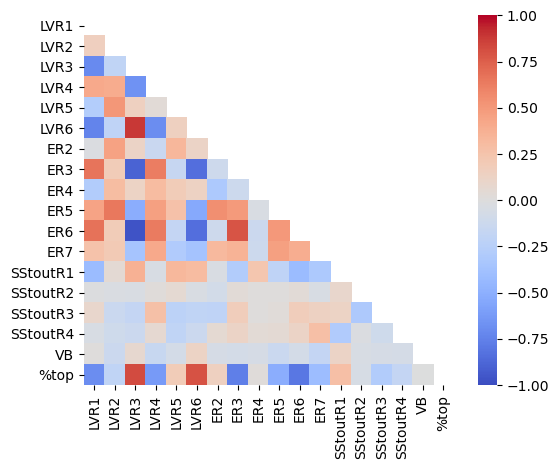

In [5]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, cmap='coolwarm', vmin=-1, vmax=1, annot=False, square=True, mask=mask, annot_kws={"fontsize": 4})
plt.show()

## Splitting and scaling the data
We can now split our data into the features 'X' and the target variable 'Y'. We then scale the features using a 'Robust Scaler'.


In [17]:
X = data.drop([target_variable], axis = 1)
#X = np.array(X)
X = RobustScaler().fit_transform(np.array(X))
y = data[target_variable]/100

## Simple ML
For the most basic ML, we can split the data into a training set and a testing set, in a 9:1 size ratio. We then define our model:

Linear Regression: model = LinearRegression()

Random Forest: model = RandomForestRegressor()

We first train this model on the traning set, so it can look for trends within the data. We can then use this trained model to make predictions on the witheld testing set. Following this, we score these predictions by calculating R2 and RMSE.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = math.sqrt(mean_squared_error(predictions, y_test))
print('R2:', np.round(r2, 3))
print('RMSE:', np.round(rmse, 3))

R2: 0.837
RMSE: 0.18


## Cross-Validation
If we run the code in the previous section multiple times we get different results! This is beacuse the ability for the machine to predict on the testing set depends on whether it has seen similar examples in the training set. We need a method for getting more consistent results.

Cross-Validation is a method for more rigourously measuring the performance of our models. Instead of splitting the data into 2 sets, we split it into (usually) 5. For each iteration, we keep one of the 5 sets separate to use as a testing set, and the remaining 4 are used for training (just like we did previously). We repeat this 5 times, using a different set as the testing set each time.

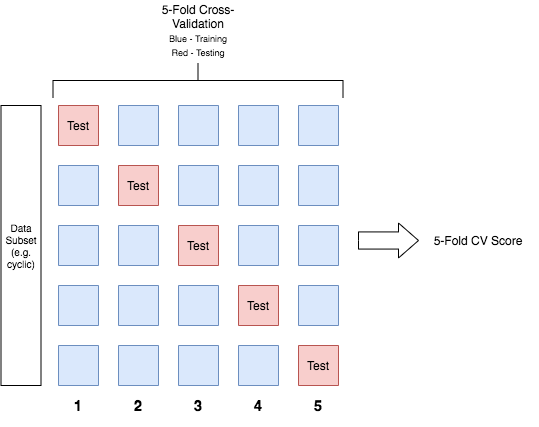
Before CV, we define r2_cv_scores and rmse_cv_scores as 'containers' where we will put our results. We can then calculate the mean and standard deviation of each of the results stored in these 'containers'.

In [34]:
r2_cv_scores = []
rmse_cv_scores = []
all_predictions = np.array([])
all_trues = np.array([])
kfold = KFold(n_splits=5, shuffle = True)
for train, test in kfold.split(X, y):
    model = LinearRegression()
    model.fit(X[train], y[train])
    predictions = model.predict(X[test]).reshape(1, -1)[0]
    #print(pd.DataFrame({'Predictions':predictions, 'Actual': y[test], 'Error': [a for b in range(len(predictions)) 
    #                                                                            if y[test][b]-predictions[b]>0.1]}))
    r2 = r2_score(y[test], predictions)
    rmse = math.sqrt(mean_squared_error(predictions, y[test]))
    r2_cv_scores.append(r2)
    rmse_cv_scores.append(rmse)
    all_predictions = np.append(all_predictions, predictions)
    all_trues = np.append(all_trues, y[test])

print('CV R2 Mean: ', np.round(np.mean(np.array(r2_cv_scores)), 3), '+/-', np.round(np.std(np.array(r2_cv_scores)), 2))
print('CV RMSE Mean: ', np.round(np.mean(np.array(rmse_cv_scores)), 3), '+/-', np.round(np.std(np.array(rmse_cv_scores)), 2), '\n')


CV R2 Mean:  0.424 +/- 0.61
CV RMSE Mean:  0.263 +/- 0.13 



## Visualising the Results
Now that we have our R2 and RMSE scores, it would be great if we could visualise what these mean. One common method for this is to plot the predicted results against the actual results. In this context, thats plotting the predicted %top against the actual experimental %top.
A perfect prediction would lie somewhere on the line y=x (predicted = true). 
As not all predictions will be perfect, we can plot a line of best fit y=ax + b and calculate both a and b. A good model would result in a close to 1, and b close to 0. We can plot this line of best fit too.

a: 0.7887066017473159  b: 0.06259471299928934  R: 0.841578080955935
y = ax + b (red)  R = correlation coefficient
and y=x (blue)


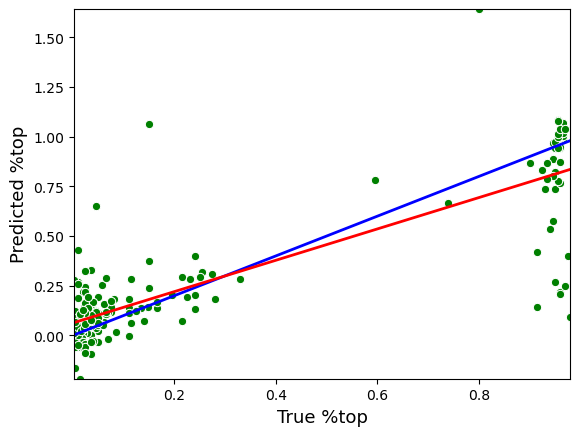

In [9]:
def calc_a_b(ac, pred):
    x = np.sum(ac)
    y = np.sum(pred)
    x2 = np.sum(np.square(ac))
    y2 = np.sum(np.square(pred))
    xy = np.sum(ac*pred)
    n = len(ac)
    a = (n*xy - x*y)/(n*x2 - x**2)
    b = (y*x2 - x*xy)/(n*x2 - x**2)
    R = (n*xy - x*y)/math.sqrt((n*x2 - x**2)*(n*y2 - y**2))
    print(f"a: {a}  b: {b}  R: {R}")
    print('y = ax + b (red)  R = correlation coefficient')
    print('and y=x (blue)')
    return a, b, R


a, b, R = calc_a_b(all_trues, all_predictions)

ax = sns.scatterplot(x=all_trues, y=all_predictions, color='g')
ax.set_xlabel(str("True "+ target_variable), fontsize=13)
ax.set_ylabel(str("Predicted "+ target_variable), fontsize=13)
plt.xlim(np.min(all_trues), np.max(all_trues))
plt.ylim(np.min(all_predictions), np.max(all_predictions))
plt.plot([-1000, 1000], [-1000, 1000], color='b', linewidth=2)
plt.plot([0, 1], [0 * a + b, 1 * a + b], color='r', linewidth=2)

plt.show()